In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
from time import sleep
import os
import numpy as np
from sklearn.metrics import classification_report

from amb_sdk.sdk import DarwinSdk
import datetime
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())

In [2]:
# Login
from login import username, password
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user(username, password)

if not status:
    print(msg)
else:
    print('You are logged in!')

You are logged in!


In [3]:
def get_formatted_dataframe(xls_file, year):
    df = pd.read_excel(xls_file)
    df = df[['DZRATING', 'DZCAMPUS','DPETALLC','DA0AT' + str(year) + 'R', 'DA0912DR' + str(year) + 'R','DAGC4X' + str(year) + 'R','DAGC5X' + str(year - 1) + 'R','DA0GR' + str(year) + 'N','DA0CT' + str(year) + 'R','DA0CC' + str(year) + 'R','DA0CSA' + str(year) + 'R','DA0CAA' + str(year) + 'R','DPSTTOSA','DPSTEXPA','DPFRAALLT','DPFRAALLK','DPFRASTAP','DZRVLOCP','DPFRAFEDP','DPFEAINST','DPFEAINSK','DISTSIZE','COMMTYPE', 'PROPWLTH', 'TAXRATE']]
    df = df.rename(index=str, columns = {"DZRATING":"rating", "DZCAMPUS":"num_schools", "DPETALLC":"num_students", "DA0AT" + str(year) + "R":"attendance_rate", "DA0912DR" + str(year) + "R":"dropout_rate", "DAGC4X" + str(year) + "R":"grad_rate_4_year", "DAGC5X" + str(year - 1) + "R":"grad_rate_5_year", "DA0GR" + str(year) + "N":"annual_grad_count", "DA0CT" + str(year) + "R":"college_admissions_per_tested", "DA0CC" + str(year) + "R":"college_admissions_at_crit", "DA0CSA" + str(year) + "R":"average_sat", "DA0CAA" + str(year) + "R":"average_act", "DPSTTOSA":"average_teacher_salary", "DPSTEXPA":"average_teacher_exp", "DPFRAALLT":"total_revenue", "DPFRAALLK":"total_revenue_per_pupil", "DPFRASTAP":"percent_revenue_from_state", "DZRVLOCP":"percent_revenue_from_local", "DPFRAFEDP":"percent_revenue_from_federal", "DPFEAINST":"instr_expenditures", "DPFEAINSK":"instr_expenditures_per_pupil", "DISTSIZE":"district_size", "COMMTYPE":"community_type", "PROPWLTH":"property_wealth", "TAXRATE":"tax_rate"})
    return df

In [4]:
test_df = get_formatted_dataframe('2016-2017.xls', 16)
train_df = get_formatted_dataframe('2015-2016.xls',15)
train_df = train_df.append(get_formatted_dataframe('2014-2015.xls',14))
train_df = train_df.append(get_formatted_dataframe('2013-2014.xls',13))
train_df = train_df.loc[(train_df['rating'] == "Met Standard") | (train_df['rating'] == "Met Alternative Standard") |(train_df['rating'] == "Improvement Required")]
test_df = test_df.loc[(test_df['rating'] == "Met Standard") | (test_df['rating'] == "Met Alternative Standard") |(test_df['rating'] == "Improvement Required")]
print('Test dataframe shape:', test_df.shape)
print('Train dataframe shape:', train_df.shape)
train_df.head()

Test dataframe shape: (1190, 25)
Train dataframe shape: (3618, 25)


,rating,num_schools,num_students,attendance_rate,dropout_rate,grad_rate_4_year,grad_rate_5_year,annual_grad_count,college_admissions_per_tested,college_admissions_at_crit,...,total_revenue_per_pupil,percent_revenue_from_state,percent_revenue_from_local,percent_revenue_from_federal,instr_expenditures,instr_expenditures_per_pupil,district_size,community_type,property_wealth,tax_rate
0,Met Standard,3,568,96,1.4,93.3,89.2,56,66.1,10.8,...,14856,41.2,40.5,18.4,4699444,8145,500 to 999,Rural,"$434,690 to < $497,197",Under $1.1461
1,Met Standard,4,1244,96.5,0,95.8,98.7,73,68.5,16,...,10165,58.6,36.6,4.9,6045264,4967,"1,000 to 1,599",Non-metropolitan Stable,"$216,001 to < $241,215",$1.2543 to under $1.3801
2,Met Standard,3,841,95.9,0.4,97.7,100,43,32.6,0,...,11132,47.5,47.3,5.3,3788907,4718,500 to 999,Rural,"$319,192 to < $340,879",$1.3801 and over
3,Met Standard,3,383,95.5,1.6,90.9,97.6,29,34.5,40,...,11421,53.1,41.7,5.3,2067502,5588,Under 500,Rural,"$305,220 to < $319,192",$1.2543 to under $1.3801
4,Met Standard,6,3385,95.8,0.7,87.6,97.8,175,41.7,15.1,...,11450,41.8,44.7,13.5,17594931,5249,"3,000 to 4,999",Independent Town,"$277,857 to < $305,220",$1.3801 and over


In [5]:
# #Dealing with class imbalance
# print("Before upsampling:")
# print("Met Standard:", train_df.loc[train_df['rating'] == "Met Standard"].shape[0])
# print("Met Alternative Standard:", train_df.loc[train_df['rating'] == "Met Alternative Standard"].shape[0])
# print("Improvement Required:", train_df.loc[train_df['rating'] == "Improvement Required"].shape[0])
# print()

# from sklearn.utils import resample
# from imblearn.over_sampling import RandomOverSampler
# #train_df_majority = train_df[train_df['rating'] == 'Met Standard']
# #train_df_minority_improvement = train_df[train_df['rating'] == 'Improvement Required']
# #train_df_minority_alternative = resample(train_df_minority_alternative, replace=True, n_samples = 200, random_state=123)
# #train_df_minority_improvement = resample(train_df_minority_improvement, replace=True, n_samples = 500, random_state=123)
# #train_df_upsampled = pd.concat([train_df_majority, train_df_minority_alternative, train_df_minority_improvement])
# #train_df = train_df_upsampled

# ad = RandomOverSampler(random_state=12, ratio = 1.0)
# train_df_y = train_df["rating"]
# train_df_x = train_df.iloc[:,1:21]
# x_res, y_res = ad.fit_sample(train_df_x, train_df_y)
# print(x_res)
# #print(train_df_x)

# print("After upsampling:")
# print("Met Standard:", train_df.loc[train_df['rating'] == "Met Standard"].shape[0])
# print("Met Alternative Standard:", train_df.loc[train_df['rating'] == "Met Alternative Standard"].shape[0])
# print("Improvement Required:", train_df.loc[train_df['rating'] == "Improvement Required"].shape[0])
# #train_df

In [6]:
test_df.to_csv('test_data.csv')
train_df.to_csv('train_data.csv')

In [7]:
TRAIN_DATASET='train_data.csv'
TEST_DATASET = 'test_data.csv'
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')
status, message = ds.delete_dataset(TRAIN_DATASET)
status, dataset = ds.upload_dataset( TRAIN_DATASET)
if not status:
    print(dataset)

In [8]:
#clean train_Set
target = "rating"
status, job_id = ds.clean_data(TRAIN_DATASET, target = target)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-20T18:07:24.083002', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train_data.csv'], 'artifact_names': ['eaef46cb7c7e421d8ecbdbd84c482719'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-20T18:07:24.083002', 'endtime': '2019-04-20T18:07:27.549359', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train_data.csv'], 'artifact_names': ['eaef46cb7c7e421d8ecbdbd84c482719'], 'model_name': None, 'job_error': ''}


In [9]:
dataset = ds.download_dataset(job_id['artifact_name'], artifact_path='/Users/ctjoe/Documents/CS363D/darwin/darwin-sdk/sc_proj')
print(dataset)

(True, {'filename': '/Users/ctjoe/Documents/CS363D/darwin/darwin-sdk/sc_proj/eaef46cb7c7e421d8ecbdbd84c482719-cleaned-e3htjewg.csv'})


In [10]:
clean_train_df = pd.read_csv(dataset[1]['filename'])

clean_train_df['rating'] = 'N/A'
clean_train_df.loc[clean_train_df['rating$$Met Standard'] == 1.0, 'rating'] = 1.0
clean_train_df.loc[clean_train_df['rating$$Met Alternative Standard'] == 1.0, 'rating'] = 2.0
clean_train_df.loc[clean_train_df['rating$$Improvement Required'] == 1.0, 'rating'] = 0
labels = list(clean_train_df)
labels.remove('rating$$Improvement Required')
labels.remove('rating$$Met Alternative Standard')
labels.remove('rating$$Met Standard')
clean_train_df = clean_train_df[labels]
labels.remove('rating')

from imblearn.over_sampling import SMOTE
ad = SMOTE(random_state=12, ratio = 1.0)
clean_train_df_y = clean_train_df['rating']
clean_train_df_x = clean_train_df.iloc[:,1:50]
x_res, y_res = ad.fit_sample(clean_train_df_x, clean_train_df_y)

train_df = pd.DataFrame(data=x_res, columns=labels)
train_df['rating'] = y_res
train_df.loc[train_df['rating'] == 1.0, 'rating'] = 'Met Standard'
train_df.loc[train_df['rating'] == 2.0, 'rating'] = 'Met Alternative Standard'
train_df.loc[train_df['rating'] == 0.0, 'rating'] = 'Improvement Required'
print("After oversampling:")
print(train_df['rating'].value_counts())


/anaconda3/lib/python3.6/site-packages/imblearn/utils/validation.py:77: UserWarning: 'y' should be of types ('binary', 'multiclass') only. Got unknown instead.
  TARGET_KIND, type_of_target(y)))
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


After oversampling:
Improvement Required        3300
Met Standard                3300
Met Alternative Standard    3300
Name: rating, dtype: int64


In [11]:
train_df.to_csv('upsample_train_data.csv')
UPSAMPLE_TRAIN_DATASET = 'upsample_train_data.csv'
upsample_train_df = pd.read_csv('upsample_train_data.csv')
status, message = ds.delete_dataset(UPSAMPLE_TRAIN_DATASET)
status, dataset = ds.upload_dataset( UPSAMPLE_TRAIN_DATASET)
if not status:
    print(dataset)

In [12]:
#clean train_Set
target = "rating"
status, job_id = ds.clean_data(UPSAMPLE_TRAIN_DATASET, target = target)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-20T18:07:42.922975', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['upsample_train_data.csv'], 'artifact_names': ['098115409ff6494b8e6f9ea147d15553'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-20T18:07:42.922975', 'endtime': '2019-04-20T18:07:48.977168', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['upsample_train_data.csv'], 'artifact_names': ['098115409ff6494b8e6f9ea147d15553'], 'model_name': None, 'job_error': ''}


In [13]:
model = target + "_model01" + ts
status, job_id = ds.create_model(dataset_names = UPSAMPLE_TRAIN_DATASET, \
                                 model_name =  model, \
                                 max_train_time = '00:02')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-20T18:07:59.164597', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['upsample_train_data.csv'], 'artifact_names': None, 'model_name': 'rating_model0120190420180709', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-20T18:07:59.164597', 'endtime': None, 'percent_complete': 7, 'job_type': 'TrainModel', 'loss': 0.5514952540397644, 'generations': 2, 'dataset_names': ['upsample_train_data.csv'], 'artifact_names': None, 'model_name': 'rating_model0120190420180709', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T18:07:59.164597', 'endtime': None, 'percent_complete': 12, 'job_type': 'TrainModel', 'loss': 0.5514952540397644, 'generations': 3, 'dataset_names': ['upsample_train_data.csv'], 'artifact_names': None, 'model_name': 'rating_model0120190420180709', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T18:07:59.164597', 'endtime': Non

In [14]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])


{'status': 'Running', 'starttime': '2019-04-20T18:10:15.937045', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.5514952540397644, 'generations': 3, 'dataset_names': None, 'artifact_names': ['26bc40c0be8742848c7d4c78b30864dd'], 'model_name': 'rating_model0120190420180709', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T18:10:15.937045', 'endtime': '2019-04-20T18:10:17.360452', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.5514952540397644, 'generations': 3, 'dataset_names': None, 'artifact_names': ['26bc40c0be8742848c7d4c78b30864dd'], 'model_name': 'rating_model0120190420180709', 'job_error': ''}


In [15]:
feature_importance[:10]

Unnamed: 0                        0.339206
tax_rate = Under $1.1461 = 1.0    0.178195
tax_rate = Under $1.1461 = 2.0    0.135927
num_students                      0.062221
average_sat                       0.033918
tax_rate = $1.3801 and over       0.032301
annual_grad_count                 0.031804
total_revenue_per_pupil           0.026496
percent_revenue_from_state        0.021441
average_teacher_salary            0.015740
dtype: float64

In [16]:
status, artifact = ds.run_model(UPSAMPLE_TRAIN_DATASET, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2019-04-20T18:10:33.50678', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.5514952540397644, 'generations': 3, 'dataset_names': ['upsample_train_data.csv'], 'artifact_names': ['1565fe8b58e6488484b9a80465e30710'], 'model_name': 'rating_model0120190420180709', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-20T18:10:33.50678', 'endtime': '2019-04-20T18:10:34.678952', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.5514952540397644, 'generations': 3, 'dataset_names': ['upsample_train_data.csv'], 'artifact_names': ['1565fe8b58e6488484b9a80465e30710'], 'model_name': 'rating_model0120190420180709', 'job_error': ''}


(True, 'Job completed')

In [17]:
status, prediction = ds.download_artifact(artifact['artifact_name'])
prediction.head()

,prob_Improvement Required,prob_Met Alternative Standard,prob_Met Standard,rating
0,0.000020,8.526000e-07,0.999979,Met Standard
1,0.000008,1.827000e-07,0.999991,Met Standard
2,0.000041,5.563000e-07,0.999958,Met Standard
3,0.000019,6.173000e-07,0.999981,Met Standard
4,0.000008,1.142100e-06,0.999991,Met Standard


                          precision    recall  f1-score   support

    Improvement Required       1.00      1.00      1.00      3300
Met Alternative Standard       1.00      1.00      1.00      3300
            Met Standard       1.00      1.00      1.00      3300

             avg / total       1.00      1.00      1.00      9900



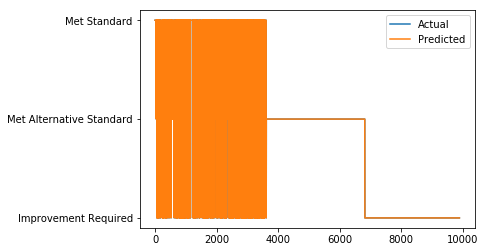

In [18]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(upsample_train_df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(upsample_train_df[target], prediction[target]))

In [19]:
#TEST DATASET
status, message = ds.delete_dataset(TEST_DATASET)
status, dataset = ds.upload_dataset( TEST_DATASET)
if not status:
    print(dataset)

In [20]:
status, job_id = ds.clean_data(TEST_DATASET, target = target)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-20T18:10:52.257838', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test_data.csv'], 'artifact_names': ['912426c1773648bd95377eb6b8866d33'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-20T18:10:52.257838', 'endtime': '2019-04-20T18:10:55.083903', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test_data.csv'], 'artifact_names': ['912426c1773648bd95377eb6b8866d33'], 'model_name': None, 'job_error': ''}


In [21]:
dataset = ds.download_dataset(job_id['artifact_name'], artifact_path='/Users/ctjoe/Documents/CS363D/darwin/darwin-sdk/sc_proj')
print(dataset)

(True, {'filename': '/Users/ctjoe/Documents/CS363D/darwin/darwin-sdk/sc_proj/912426c1773648bd95377eb6b8866d33-cleaned-egfnkcgp.csv'})


In [22]:
clean_test_df = pd.read_csv(dataset[1]['filename'])
clean_test_df['rating'] = 'N/A'
clean_test_df.loc[clean_test_df['rating$$Met Standard'] == 1.0, 'rating'] = 1.0
clean_test_df.loc[clean_test_df['rating$$Met Alternative Standard'] == 1.0, 'rating'] = 2.0
clean_test_df.loc[clean_test_df['rating$$Improvement Required'] == 1.0, 'rating'] = 0
labels = list(clean_test_df)
labels.remove('rating$$Improvement Required')
labels.remove('rating$$Met Alternative Standard')
labels.remove('rating$$Met Standard')
clean_test_df = clean_test_df[labels]
labels.remove('rating')
clean_test_df.loc[clean_test_df['rating'] == 1.0, 'rating'] = 'Met Standard'
clean_test_df.loc[clean_test_df['rating'] == 2.0, 'rating'] = 'Met Alternative Standard'
clean_test_df.loc[clean_test_df['rating'] == 0.0, 'rating'] = 'Improvement Required'


In [23]:
clean_test_df.to_csv('modified_test_data.csv')
MODIFIED_TEST_DATASET = 'modified_test_data.csv'
modified_test_df = pd.read_csv('modified_test_data.csv')
status, message = ds.delete_dataset(MODIFIED_TEST_DATASET)
status, dataset = ds.upload_dataset(MODIFIED_TEST_DATASET)
if not status:
    print(dataset)

In [24]:

status, job_id = ds.clean_data(MODIFIED_TEST_DATASET, target = target, model_name = model)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-20T18:11:09.671429', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['modified_test_data.csv'], 'artifact_names': ['3e4fd15d7afc4207be3d0de617debddf'], 'model_name': None, 'job_error': None}
{'status': 'Failed', 'starttime': '2019-04-20T18:11:09.671429', 'endtime': '2019-04-20T18:11:10.110528', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['modified_test_data.csv'], 'artifact_names': ['3e4fd15d7afc4207be3d0de617debddf'], 'model_name': None, 'job_error': "ColumnHeaderMismatch: Dataset missing column(s) : {'tax_rate$$$1.2543 to under $1.3801', 'tax_rate$$$1.3690 and over', 'tax_rate$$$1.3801 and over', 'tax_rate$$$1.3593 and over', 'tax_rate$$$1.2365 to under $1.3593', 'tax_rate$$$1.1398 to under $1.2401', 'tax_rate$$$1.2401 to under $1.3690', 'tax_rate$$Under $1.1251', 'tax_rate$$Under $1.1398', 'tax_rate$$$1

In [25]:
status, artifact = ds.run_model(MODIFIED_TEST_DATASET, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2019-04-20T18:11:25.896529', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.5514952540397644, 'generations': 3, 'dataset_names': ['modified_test_data.csv'], 'artifact_names': ['02290a1a795f45e788e514364d507043'], 'model_name': 'rating_model0120190420180709', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-20T18:11:25.896529', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.5514952540397644, 'generations': 3, 'dataset_names': ['modified_test_data.csv'], 'artifact_names': ['02290a1a795f45e788e514364d507043'], 'model_name': 'rating_model0120190420180709', 'job_error': ''}
{'status': 'Failed', 'starttime': '2019-04-20T18:11:25.896529', 'endtime': '2019-04-20T18:11:42.29161', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.5514952540397644, 'generations': 3, 'dataset_names': ['modified_test_data.csv'], 'artifact_names': ['02290a1a795f45e788e514364d507043'], 'model_name': 'rating_

(False,
 {'status': 'Failed',
  'starttime': '2019-04-20T18:11:25.896529',
  'endtime': '2019-04-20T18:11:42.29161',
  'percent_complete': 100,
  'job_type': 'RunModel',
  'loss': 0.5514952540397644,
  'generations': 3,
  'dataset_names': ['modified_test_data.csv'],
  'artifact_names': ['02290a1a795f45e788e514364d507043'],
  'model_name': 'rating_model0120190420180709',
  'job_error': 'FailedDownload: Failed to download entity of type Object from location artifacts/f08afcf0-4f34-11e9-ba76-8373fa49bc19_3e4fd15d7afc4207be3d0de617debddf/data.csv'})

In [26]:
# Create plots comparing predictions with actual target
status, prediction = ds.download_artifact(artifact['artifact_name'])
df = pd.read_csv(MODIFIED_TEST_DATASET)
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))

TypeError: string indices must be integers